# Analysis of User Behavior in a Mobile App

**Project Goal**

Understand user behavior in a mobile application that sells food products.

**Project Objectives**

- Analyze the sales funnel. Determine how users progress towards making a purchase. How many users complete the purchase, and how many get "stuck" at previous steps? At which steps specifically?
- Investigate the results of an A/A/B experiment. Designers wanted to change the fonts throughout the app, but managers were concerned that users might find it unfamiliar. They agreed to make a decision based on the results of an A/A/B test. Users were divided into 3 groups: 2 control groups with the old fonts and one experimental group with the new fonts. We'll determine which font performs better.

**Data Description**

Each log entry represents a user action or event.  
`EventName` — event name  
`DeviceIDHash` — unique user identifier  
`EventTimestamp` — event timestamp  
`ExpId` — experiment ID: 246 and 247 are control groups, and 248 is the experimental group.

## Data review and preprocessing

### Data review

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from plotly import graph_objects as go
import math as mth

In [2]:
data = pd.read_csv('/Users/a1/Downloads/logs_exp.csv', sep='\t')
display(data.head(10))
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [3]:
# data overview
print(data['EventName'].unique())
print(data['ExpId'].unique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
[246 248 247]


The dataframe contains information about 224126 events. There are 5 types of events in total.  
There are no missing values in the dataframe, but the EventTimestamp column has been assigned an incorrect data type (most likely the time is specified in seconds) and the column names are not written in accordance with the code style.

### Data preprocessing

In [4]:
# rename names of the columns
data = data.rename(columns={'EventName': 'event_name', 
                            'DeviceIDHash': 'user_id', 
                            'EventTimestamp': 'event_time', 
                            'ExpId': 'group'})

# change data type in column `event_time`
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

# add column with date
data['event_date'] = pd.to_datetime(data['event_time'].dt.date)
data.head()

,event_name,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Check the duplicates

In [5]:
# find duplicates
data.duplicated().sum()

413

Delete duplicates from dataframe

In [6]:
# delete duplicates 
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   event_date  243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


Also, at the preprocessing stage, check whether users overlap in groups

In [7]:
# find users who fall into all 3 groups
overlapping_users = data.groupby('user_id')['group'].nunique()
overlapping_users = overlapping_users[overlapping_users > 1].index

# count the number of such users
overlapping_count = len(overlapping_users)
overlapping_count

0

There are no overlapping users in the groups, so we can start analyzing the data

## Examine and validate the data

### Examine events

See how many events are in the log

In [8]:
# count how many events are in the log
count_events = len(data)

# count how many unique types of events are in the log
count_unique_events = data['event_name'].nunique()

print(f'Total events in the log: {count_events}')
print(f'Unique types of events in the log: {count_unique_events}')

Total events in the log: 243713
Unique types of events in the log: 5


Calculate how many unique users there are in the log

In [9]:
# calculate how many unique users there are in the log
count_unique_users = data['user_id'].nunique()

print(f'Total unique users in the log: {count_unique_users}')

Total unique users in the log: 7551


Calculate the average number of events per user

In [10]:
# Calculate the average number of events per user
avg_events_per_user = count_events / count_unique_users

print(f'On average, each user has {avg_events_per_user:0.0f} events')

On average, each user has 32 events


### Examine the period for which data is available

In [11]:
# find the minimum date in the dataframe
print(data['event_time'].min())

# find the maximum date in the dataframe
print(data['event_time'].max())

2019-07-25 04:43:36
2019-08-07 21:15:17


We have data from July 25, 2019 to August 7, 2019

**Examine how the number of events varies depending on time**

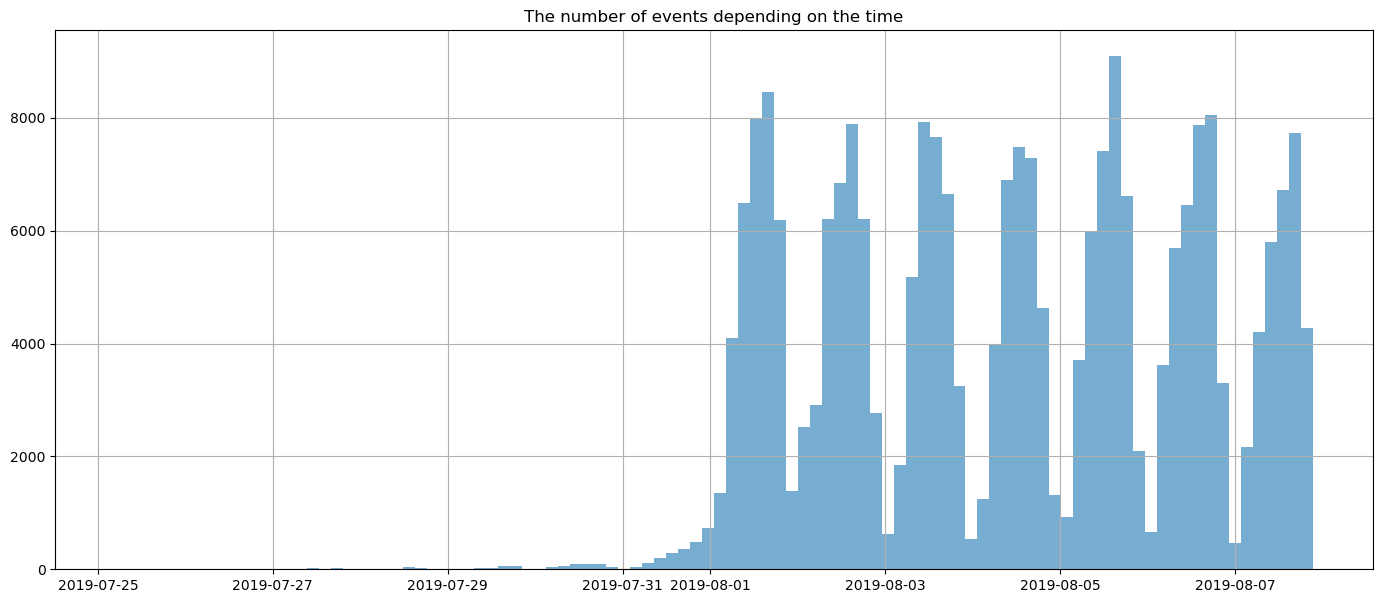

In [12]:
# build histogram 
plt.title('The number of events depending on the time')
data['event_time'].hist(bins=100, figsize=(17, 7), alpha=0.6)
plt.show()

According to the histogram, it can be seen that we have very little data for the 5 days of July 2019. The distribution looks normal starting in August 2019. Select the data starting from August 1, 2019.

In [13]:
# create a data slice based on date
data = data.query('event_time > "2019-08-01"')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   user_id     240887 non-null  int64         
 2   event_time  240887 non-null  datetime64[ns]
 3   group       240887 non-null  int64         
 4   event_date  240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


The number of events decreased from 243713 to 240887.  

**See how the number of events is distributed by day after the data is cleared**

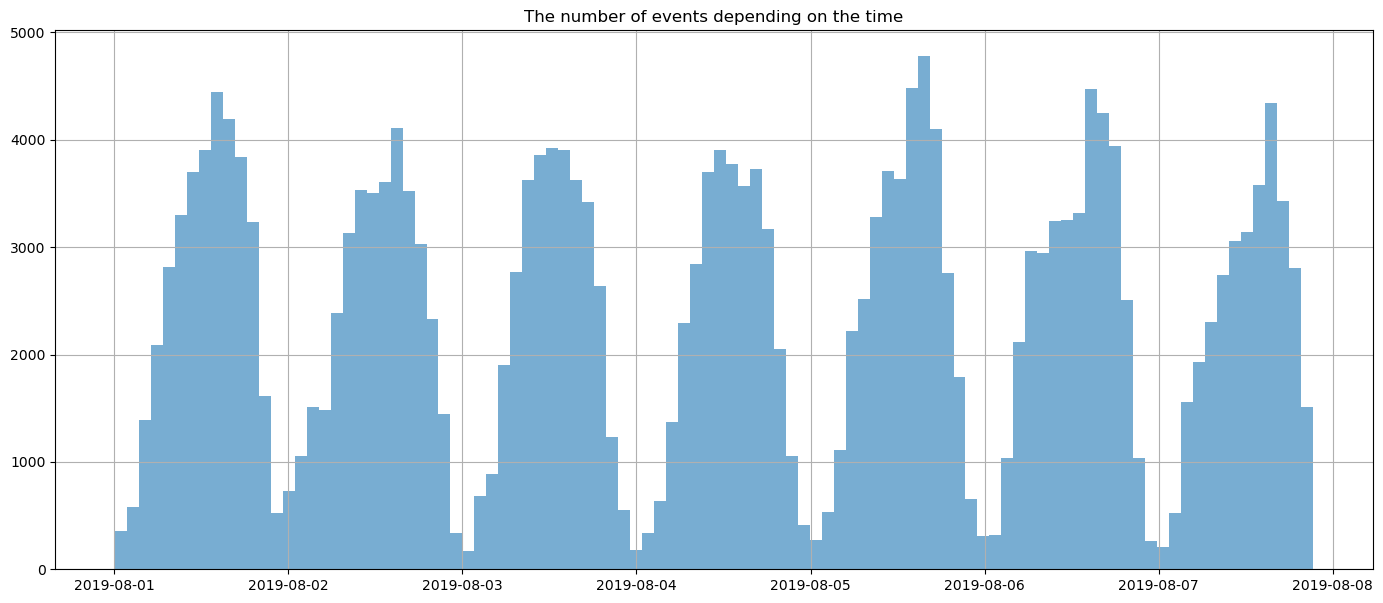

In [14]:
# build histogram
plt.title('The number of events depending on the time')
data['event_time'].hist(bins=100, figsize=(17, 7), alpha=0.6)
plt.show()

Thus, we have data from August 1, 2019 to August 7, 2019.

In [15]:
# count how many events we've lost
count_events_new = len(data)
difference_events = count_events - count_events_new
print(f'We have lost {difference_events} events from {count_events} (or {(difference_events/count_events*100):0.2f} %)')

We have lost 2826 events from 243713 (or 1.16 %)


In [16]:
# count how many users we've lost
count_unique_users_new = data['user_id'].nunique()
difference_users = count_unique_users - count_unique_users_new
print(f'We have lost {difference_users} users from {count_unique_users} (or {(difference_users/count_unique_users*100):0.2f} %)')

We have lost 17 users from 7551 (or 0.23 %)


Thus, we lost a small part of the events (2826 events or 1.16%) and a small part of the users (17 users or 0.23%). These losses are not significant

**Check if we still have users from all groups**

In [17]:
# look at the unique values of the group column
print(data['group'].unique())

[246 247 248]


After clearing the data, all the groups remained

**Conclusion**  

We took the data starting from August 1 to August 7, since the data is incomplete from July 25 to August 1.  
After clearing the data, a small number of events and users were lost.

## Examine the funnel of events

**See what events are in the logs, how often they occur.**

In [18]:
# create a table in which we count the number of events in the context of each type and sort them in descending order
events = (data.groupby('event_name', as_index=False)
              .agg({'user_id' : 'count'})
              .rename(columns={'user_id' : 'count_events'})
              .sort_values(by='count_events', ascending=False))
events 

,event_name,count_events
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


The most events are of the MainScreenAppear, the least of all are of the Tutorial

**Let's count how many users committed each of these events**  
Also, let's count the proportion of users who have ever committed an event.

In [19]:
# create a table in which we count the number of users in the context of each type and sort them in descending order
users_per_event = (data.groupby('event_name', as_index=False)
              .agg({'user_id' : 'nunique'})
              .rename(columns={'user_id' : 'count_users'})
              .sort_values(by='count_users', ascending=False))

# add a column with the percentage of users who committed the event from the total number of users
users_per_event['user_ratio'] = users_per_event['count_users'] / data['user_id'].nunique() * 100
users_per_event

,event_name,count_users,user_ratio
1,MainScreenAppear,7419,98.473586
2,OffersScreenAppear,4593,60.963632
0,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719
4,Tutorial,840,11.149456


The main screen was seen by the most users - 7419 users (or 98.5% of the total number of users)  
The least number of users watched the tutorial - 840 users (or 11% of the total number of users)

From the analysis of the type of events, it can be seen that all types are arranged in a sequential chain of events, with the exception of the Tutorial type. The tutorial on how to use the app cannot appear after payment for the product. Thus, the type of the Tutorial event will not be taken into account for calculating the funnel.  
It can be assumed that the events occur in the following order:  
- MainScreenAppear  
- OffersScreenAppear  
- CartScreenAppear  
- PaymentScreenSuccessful 

**Visualize the funnel of events**

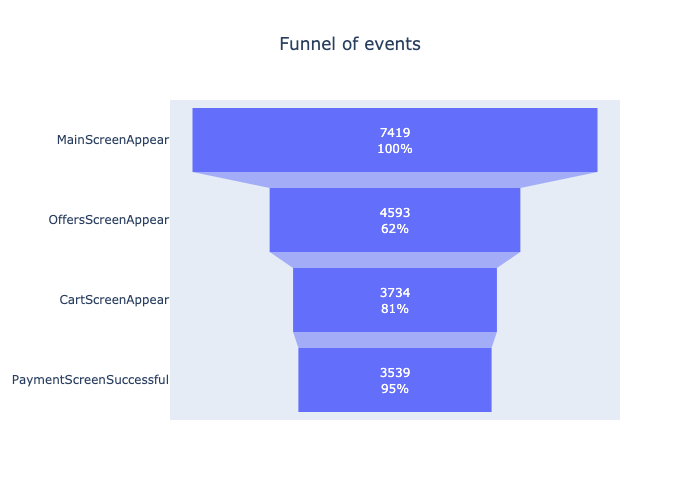

In [20]:
# removing the Tutorial event view from the table to build the funnel
users_per_event = users_per_event.query('event_name != "Tutorial"') 

# build a funnel of events
fig = go.Figure(go.Funnel(
      y = users_per_event['event_name'],
      x = users_per_event['count_users'],
      textinfo = "value + percent previous"))
fig.update_layout(title='Funnel of events', title_x = 0.5)
fig.show('png')

Based on the constructed funnel of events, where the percentage of user conversions relative to the previous event is indicated, you can see that most users are lost at the step of switching to the OffersScreenAppear offer screen (38% of users are lost, only 62% are converted)  
Approximately 48% of users reach payment from the first event

## Examine the results of the experiment

**Calculate how many users are in each experimental group**

In [21]:
# create a table in which we calculate the number of users in the context of each group
users_per_group = (data.groupby('group')
              .agg({'user_id' : 'nunique'})
              .rename(columns={'user_id' : 'count_users'})
              .sort_values(by='count_users', ascending=False))

users_per_group

,count_users
group,
248,2537
247,2513
246,2484


The number of users in all three groups is approximately the same

**Conduct an A/A test on two control groups to check the correctness of all mechanisms and calculations**

The criteria for a successful A/A test are:

- The number of users in different groups differs by no more than 1%.
- Data about the same events is recorded and sent to analytics systems for all groups.
- The difference in key metrics between groups does not exceed 1% and is not statistically significant.
- A user assigned to one group stays in that group for the entire test. If a user sees different versions of the tested page during the same test, it’s unclear which version influenced their decisions. Therefore, the results of such a test cannot be interpreted unambiguously.

Previously, we have already checked whether users overlap in different groups and concluded that users in each group are unique.  
The number of users in groups is practically the same.  
But we cannot check whether data on the same thing is recorded and sent to the analytics systems for all groups, so in this case we will omit this criterion and will not check it.  

It remains to check the key metrics in the groups.

It is necessary to check whether statistical criteria find the difference between samples 246 and 247 (to conduct an A/A test).  
To do this, we will use a statistical test to determine whether two average values of the general population differ when the variances are known and the sample size is large.  
Let's write the z-test function

In [22]:
def z_test(group_1, group_2, event, alpha, n):
    '''    
The function checks for a statistically significant difference between the two groups.
The function is fed 2 tables with data from the two groups being compared. The event
for which the check is performed, the critical level of statistical significance and
the Bonferroni correction for the critical level of statistical significance are also indicated.
    
    '''    
    
    # consider the Bonferroni amendment
    alpha_bonf = alpha / n
 
    # the total number of users in the two groups being checked
    count_users = np.array([group_1['user_id'].nunique(), group_2['user_id'].nunique()])

    # the number of users who have committed a certain event by group
    success = np.array([group_1[group_1['event_name'] == event]['user_id'].nunique(), 
                        group_2[group_2['event_name'] == event]['user_id'].nunique()])

    # the proportion of success in the first group
    p1 = success[0]/count_users[0]
    
    # the proportion of success in the second group
    p2 = success[1]/count_users[1]
    
    # the proportion of success in the combined dataset
    p_combined = (success[0] + success[1]) / (count_users[0] + count_users[1])

    # the difference in proportions in datasets
    difference = p1 - p2 

    # count statistics in the standard deviations of the standard normal distribution
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/count_users[0] + 1/count_users[1]))

    # setting the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   # the test is two-sided, double the result
    
    print('Event:', event)
    print('p-value: ', p_value)

    if p_value < alpha_bonf:
        print('Reject the null hypothesis: there is a difference between the shares')
    else:
        print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different')

To conduct the A/A test, we will establish the null and alternative hypotheses:  
**H0** - the shares of unique visitors of the groups being tested are the same  
**H1** - the shares of unique visitors from the groups being checked are the same

Let's take the significance level equal to 0.05, and to calculate the Bonnferoni correction, we need to take n = 16, since we will have 16 checks for which we will analyze

In [23]:
# check if there is a statistically significant difference between control groups 246 and 247

for event in users_per_event['event_name'].unique():
    z_test(data[data['group'] == 246], data[data['group'] == 247], event, 0.05, 16)
    print()

Event: MainScreenAppear
p-value:  0.7570597232046099
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: OffersScreenAppear
p-value:  0.2480954578522181
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: CartScreenAppear
p-value:  0.22883372237997213
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: PaymentScreenSuccessful
p-value:  0.11456679313141849
It was not possible to reject the null hypothesis, there is no reason to consider the shares different



Based on the A/A test, it can be concluded that there is no significant difference between control groups 246 and 247.  
Therefore, we can proceed to the A/B test

**Conduct an A/B test with each of the control groups separately for each event**

Use the previously written function and check the difference between groups 246 and 248

In [24]:
# check if there is a statistically significant difference between control groups 246 and 248

for event in users_per_event['event_name'].unique():
    z_test(data[data['group'] == 246], data[data['group'] == 248], event, 0.05, 16)
    print()

Event: MainScreenAppear
p-value:  0.2949721933554552
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: OffersScreenAppear
p-value:  0.20836205402738917
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: CartScreenAppear
p-value:  0.07842923237520116
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: PaymentScreenSuccessful
p-value:  0.2122553275697796
It was not possible to reject the null hypothesis, there is no reason to consider the shares different



There is practically no difference in proportions at the specified sample sizes, therefore we cannot talk about a statistically significant difference. This means that the control group 246 does not differ from the experimental group 248

Use the previously written function and check the difference between groups 247 and 248

In [25]:
# check if there is a statistically significant difference between control groups 247 and 248

for event in users_per_event['event_name'].unique():
    z_test(data[data['group'] == 247], data[data['group'] == 248], event, 0.05, 16)
    print()

Event: MainScreenAppear
p-value:  0.4587053616621515
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: OffersScreenAppear
p-value:  0.9197817830592261
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: CartScreenAppear
p-value:  0.5786197879539783
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: PaymentScreenSuccessful
p-value:  0.7373415053803964
It was not possible to reject the null hypothesis, there is no reason to consider the shares different



There is practically no difference in proportions at the specified sample sizes, therefore we cannot talk about a statistically significant difference. This means that the control group 247 does not differ from the experimental group 248

Check if there is a statistically significant difference between the combined control and experimental 248 groups

In [26]:
# check if there is a statistically significant difference between the combined control and experimental 248 groups

for event in users_per_event['event_name'].unique():
    z_test(data[data['group'] != 248], data[data['group'] == 248], event, 0.05, 16)
    print()

Event: MainScreenAppear
p-value:  0.29424526837179577
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: OffersScreenAppear
p-value:  0.43425549655188256
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: CartScreenAppear
p-value:  0.18175875284404386
It was not possible to reject the null hypothesis, there is no reason to consider the shares different

Event: PaymentScreenSuccessful
p-value:  0.6004294282308704
It was not possible to reject the null hypothesis, there is no reason to consider the shares different



There is practically no difference in proportions at the specified sample sizes, therefore we cannot talk about a statistically significant difference. This means that the combined control group does not differ from the experimental 248

## Conclusion

**During the analysis, data was preprocessed for the convenience and correctness of further research**  
As part of the preprocessing, the data type of the column with the date was changed, the column names were changed, obvious duplicates were removed, and also a check was carried out for the intersection of users in different groups.  

**The data has been examined**  
We took the data starting from August 1 to August 7, because the data is incomplete from July 25 to August 1.
After clearing the data, a small number of events and users were lost.  

**The funnel of events has been examined**  
We concluded that events occur in the following order:  
- MainScreenAppear  
- OffersScreenAppear  
- CartScreenAppear  
- PaymentScreenSuccessful 

We have built an event funnel where the percentage of user conversions relative to the previous event is indicated. From it, we concluded that most users are lost at the step of switching to the OffersScreenAppear offer screen (38% of users are lost, only 62% are converted). Approximately 48% of users reach payment from the first event  

**The results of the experiment were examined**  
To conduct the A/A and A/B tests, we applied the statistical significance level alpha - 0.05 with a Bonnferoni correction for 16 checks.  
We conducted an A/A test between two control groups and concluded that there was no significant difference between control groups 246 and 247.  
After that, we conducted an A/B test with each of the control groups separately for each event.  
Based on the results of the A/B test, we were convinced that changing fonts throughout the app did not affect user behavior.